# Examples

Below we show three examples of the mx_viz functions. Please see the `slide_figures.ipynb` and the OHBM 2020 multilayer network educational presentation for more details.

In [1]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multinetx as mx
import scipy.io as sio
import pandas as pd
import os
import sys
import mx_viz
import csv
import scipy as sp

print("Done importing packages :)")

finished defining functions
Done importing packages :)


## Create a multilayer network

Using multinetx, we will create a small multilayer (mx) network for plotting later. Note that the visualization functions will work best with _small_ mx networks. For larger mx networks, consider alternative plotting strategies found in this [2019 paper](https://onlinelibrary.wiley.com/doi/full/10.1111/cgf.13610).

Note below we will assume that all nodes exist in every layer and that nodes only connect to their counterparts in other layers.

{'weight': 0.000231043917752236}

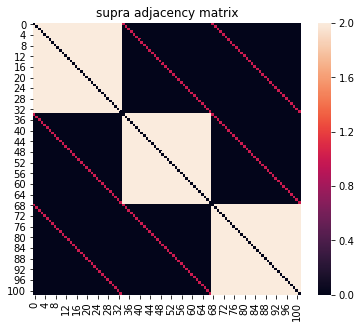

In [2]:
# Define number of nodes (number of nodes in largest layer).
nNodes = 34

# Define number of levels.
nLayers = 3

# open and write g1 as one over distance dorado
with open('data/oodahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g1 = nx.DiGraph()
g1.add_nodes_from(stars)

for r in stars:
    for c in stars:
        
        # Add edge if r != c
        if r!= c:
            g1.add_edge(r,c,weight=float(distances[r-1][c-1]))
        

# open and write g2 as saccade dorado        
with open('data/saccahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g2 = nx.DiGraph()
g2.add_nodes_from(stars)

for r in stars:
    for c in stars:
        if r != c:
            g2.add_edge(r,c,weight=float(distances[r-1][c-1]))


# open and write g3 as mags dorado
with open('data/magsahat_dorado.csv', newline='') as f:
    reader = csv.reader(f)
    distances = list(reader)
    
stars = np.arange(1,35,1)
g3 = nx.DiGraph()
g3.add_nodes_from(stars)

for r in stars:
    for c in stars:
        if r !=c:
            g3.add_edge(r,c,weight=float(distances[r-1][c-1]))

        
            
# Use multinetx to generate three graphs each on nNodes nodes.
# g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=216)
# g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=130)
# g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=81)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph with mx.
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges.
mg.set_edges_weights(intra_layer_edges_weight=2,
                    inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix to check that we actually made a multilayer network.
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

g1.get_edge_data(1,4)

### Write to json and create visualization.

The first mx_viz function writes the graph to a json file, while the second reads the file and creates an html file with the visualization. 

Below we will create two html files - one using the `theme="light"` flag and the other with `theme="dark"`.

In [ ]:
 # From the sparse adj, make a networkx graph and add node attributes
G1 = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())
G1.get_edge_data(1,2)


In [ ]:
g1.number_of_edges()
sp.special.binom(nNodes,2) *2
# 1156 - 1122= 34
g1.degree(weight="weight")[1]

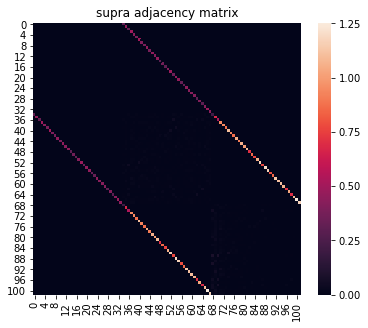

In [18]:
union1 = nx.disjoint_union(g1,g2)
union1.number_of_nodes()
graph_union = nx.disjoint_union(union1, g3)
strength_diff_g1g2 = []
strength_diff_g2g3 = []
# graph_union.number_of_nodes()
# graph_union.get_edge_data(0,3)

# Need to iterate through connected node pairs and assign inter-layer edge weights
for node1 in np.arange(nNodes) :
    
    # Find it's pair in the second layer
    node2 = node1 + nNodes
    
    # Calculate edge weight as absolute value of difference in node strengths
    strength_diff = abs(graph_union.degree(weight="weight")[node1] - graph_union.degree(weight="weight")[node2])
    if strength_diff == 0:
        print(graph_union.degree(weight="weight")[node1])
        print(graph_union.degree(weight="weight")[node2])
    
    
    # Assign edge weights
    graph_union.add_edge(node1,node2,weight = strength_diff)
    graph_union.add_edge(node2,node1,weight = strength_diff)
    
    # Add to list
    strength_diff_g1g2.append(strength_diff)
    

# Repeat for connecting layers 2,3
for node1 in np.arange(nNodes,2*nNodes) :
    
    # Find it's pair in the second layer
    node2 = node1 + nNodes
    
    # Calculate edge weight as absolute value of difference in node strengths
    strength_diff = abs(graph_union.degree(weight="weight")[node1] - graph_union.degree(weight="weight")[node2])
    
    # Assign edge weght
    graph_union.add_edge(node1,node2,weight = strength_diff)
    graph_union.add_edge(node2,node1,weight = strength_diff)
    
    # Add to list
    strength_diff_g2g3.append(strength_diff)
    
# Plot adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(nx.adjacency_matrix(graph_union,weight='weight').todense())
plt.title('supra adjacency matrix');

In [5]:
print(max(strength_diff_g2g3))
print(min(strength_diff_g2g3))

5077.700792893141
2963.0873709750285


In [7]:
# Now update the original file to take a supraadjacency matrix
from networkx.readwrite import json_graph
import json

def write_supraadj_to_json(filename, sadj, nNodes, pos, nLayers, nodes_to_remove = []):
    
    # filename the complete name of the output file (data/slide_x.json)
    # mx the multilayer network as a multinetx object
    # nNodes the number of nodes in the first layer
    # pos a dictionary of node coordinates
    # nLayers the number of layers in the second aspect.
    # nodes_to_remove is a list of nodes that should not exist in each layer. Default = []
    

    
    
    # From the sparse adj, make a networkx graph and add node attributes
#     G1 = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

    # Remove nodes from sadj
    sadj.remove_nodes_from(nodes_to_remove)

    # Recreate the graph G to make the rest work nicely.

    G = nx.from_numpy_array(nx.adjacency_matrix(sadj).todense(), create_using = nx.DiGraph)


    # Create dictionaries pretending like all nodes exist
    scalefact = 20
    L2_classes = np.arange(nLayers)
    L2_array_original = np.array([])
    z_shift = 2
    z_array_original = np.array([])
    x_orig = np.array([])
    y_orig = np.array([])
    L1_orig = np.array([])
    for level in L2_classes:
        L2_array_original = np.concatenate((L2_array_original, np.array([float(level) for i in np.arange(nNodes)])))
        z_array_original = np.concatenate((z_array_original, np.array([float(level*z_shift) for i in np.arange(nNodes)])))
        x_orig = np.concatenate((x_orig, [pos[key][0]+scalefact for key in pos]))
        y_orig = np.concatenate((y_orig, [pos[key][1]+scalefact for key in pos]))
        L1_orig = np.concatenate((L1_orig, [i for i in np.arange(nNodes)]))

    # Need to delete nodes from our attribute dictionaries, too
    L2_array = np.delete(L2_array_original, nodes_to_remove, 0)
    z_array = np.delete(z_array_original, nodes_to_remove, 0)
    x_array = np.delete(x_orig, nodes_to_remove, 0)
    y_array = np.delete(y_orig, nodes_to_remove, 0)
    L1_array = np.delete(L1_orig, nodes_to_remove, 0)

    ## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

    id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
    x_dict = {}
    y_dict = {}
    L2_dict = {i:l2 for i,l2 in enumerate(L2_array)}
    z_dict = {i:z_val for i,z_val in enumerate(z_array)}
    x_dict = {i:x_val for i,x_val in enumerate(x_array)}
    y_dict = {i:y_val for i,y_val in enumerate(y_array)}
    L1_dict = {i:L1_val for i,L1_val in enumerate(L1_array)}


    nx.set_node_attributes(G, id_dict, name = "name")
    nx.set_node_attributes(G, x_dict, name = "x")
    nx.set_node_attributes(G, y_dict, name = "y")
    nx.set_node_attributes(G, z_dict, name = "z")
    nx.set_node_attributes(G, L1_dict, name= "L1")
    nx.set_node_attributes(G, L2_dict, name= "L2")


    G_json = json_graph.node_link_data(G)
    
    # Write for visualization function
    G_json_viz = json.dumps(G_json, indent = 4)  
    
    # To save as a .json file
    with open(filename, 'w') as fp:
        json.dump(G_json, fp)

    print(f"done writing mx to {filename}")
    
    return G_json_viz

In [31]:
# We'll use networkx positioning to get nice layouts. However pos is changed (for example by 
# using a different nx.layout function), it should remain a dictionary mapping nodes to coordinate 
# arrays with at least an x and y position.
# making our own position dictionary
with open('data/x.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    x_coor = list(reader)
    
with open('data/y.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    y_coor = list(reader)
    
with open('data/z.csv', newline='') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    z_coor = list(reader)    

keys = range(1,35)
vals = []
scale_factor = 4
for i in range(len(x_coor)):
    vals.append([scale_factor*x_coor[i][0], scale_factor*y_coor[i][0], z_coor[i][0]])

    
pos = {}
for i in keys:
     pos[keys[i-1]] = vals[i-1]

#pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=2)

filename_json = "data/example2.json"
G2 = write_supraadj_to_json(filename_json,graph_union, nNodes, pos, nLayers)

filename_html_light = "visualization_output_fig3_light.html"
mx_viz.visualize(G2,theme="light",path_html=filename_html_light)

filename_html_dark = "visualization_output_fig3_dark.html"
mx_viz.visualize(G2,theme="dark",path_html=filename_html_dark);

done writing mx to data/example2.json
Wrote visualization to: visualization_output_fig3_light.html
Wrote visualization to: visualization_output_fig3_dark.html
